In [1]:
setwd('/import/DB/zhang//data')

In [2]:
library(Seurat)

Warning message:
"package 'Seurat' was built under R version 4.2.3"
The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject



In [3]:
sce = readRDS('neu.final.rds')

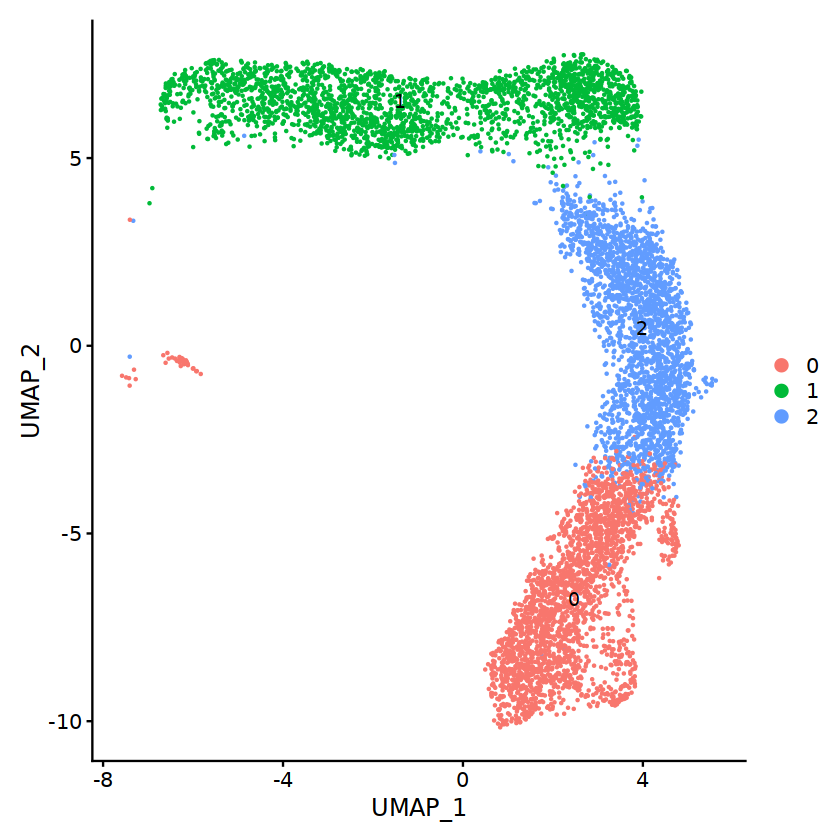

In [4]:
DimPlot(sce,reduction = 'umap',label = T)

Warning message:
"Scaling data with a low number of groups may produce misleading results"


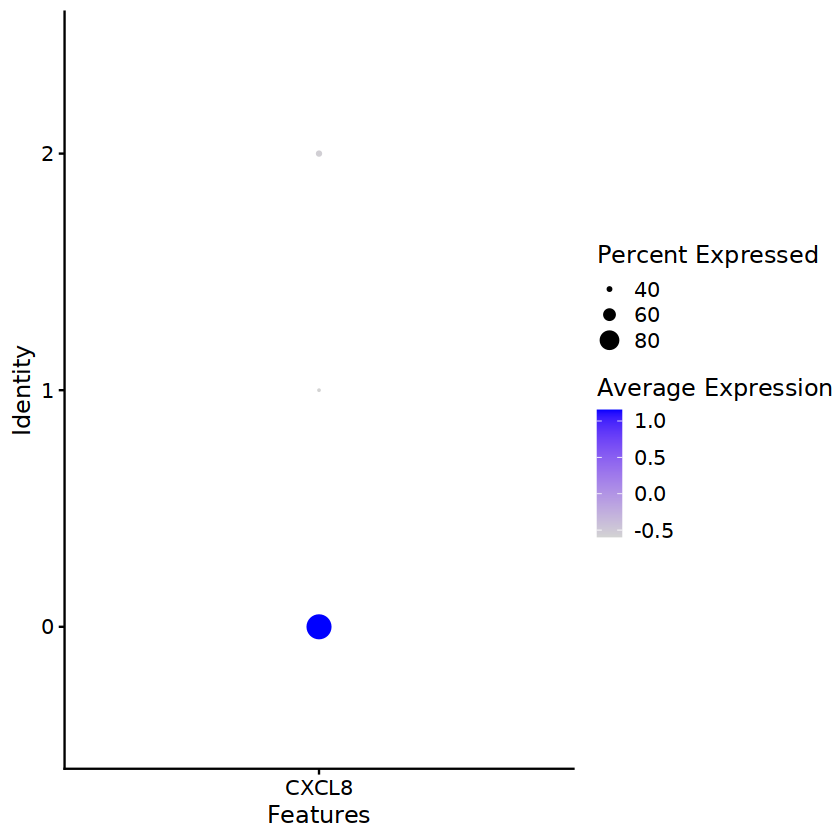

In [66]:
DotPlot(sce,features = 'CXCL8')

In [33]:
table(sce$group,sce$seurat_clusters)

         
             0    1    2    3    4    5
  OS       497    8    5    0    0    0
  control 1940 2310 2286    0    0    0

In [6]:
sce.markers = read.csv('./neu.sce.markers.csv',row.names = 1)

In [10]:
library(clusterProfiler)
library(org.Hs.eg.db)



Registered S3 methods overwritten by 'treeio':
  method              from    
  MRCA.phylo          tidytree
  MRCA.treedata       tidytree
  Nnode.treedata      tidytree
  Ntip.treedata       tidytree
  ancestor.phylo      tidytree
  ancestor.treedata   tidytree
  child.phylo         tidytree
  child.treedata      tidytree
  full_join.phylo     tidytree
  full_join.treedata  tidytree
  groupClade.phylo    tidytree
  groupClade.treedata tidytree
  groupOTU.phylo      tidytree
  groupOTU.treedata   tidytree
  is.rooted.treedata  tidytree
  nodeid.phylo        tidytree
  nodeid.treedata     tidytree
  nodelab.phylo       tidytree
  nodelab.treedata    tidytree
  offspring.phylo     tidytree
  offspring.treedata  tidytree
  parent.phylo        tidytree
  parent.treedata     tidytree
  root.treedata       tidytree
  rootnode.phylo      tidytree
  sibling.phylo       tidytree

clusterProfiler v4.6.2  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProf

In [11]:
library(dplyr) 
# 不同seurat版本的 avg_logFC 不一样 
top50 <- sce.markers %>% group_by(cluster) %>% top_n(1000, avg_log2FC)

In [12]:
group <- data.frame(gene=top50$gene,
                    group=top50$cluster)


Gene_ID <- bitr(top50$gene, fromType="SYMBOL", 
            toType="ENTREZID", 
            OrgDb="org.Hs.eg.db")

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(top50$gene, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
"3.09% of input gene IDs are fail to map..."


In [13]:
data  <- merge(Gene_ID,group,by.x='SYMBOL',by.y='gene')
data_GO <- compareCluster(
  ENTREZID~group, 
  data=data, 
  fun="enrichGO", 
  OrgDb="org.Hs.eg.db",
  ont = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff = 0.05,
  qvalueCutoff = 0.05,
  readable = TRUE
)

In [14]:
data_GO_sim <- simplify(data_GO, 
                        cutoff=0.5, 
                        by="p.adjust", 
                        select_fun=min)
write.csv(data_GO_sim@compareClusterResult,file = 'NEU.goenrichment.csv',row.names =F)

In [18]:
library(ggplot2)

Warning message:
"package 'ggplot2' was built under R version 4.2.3"


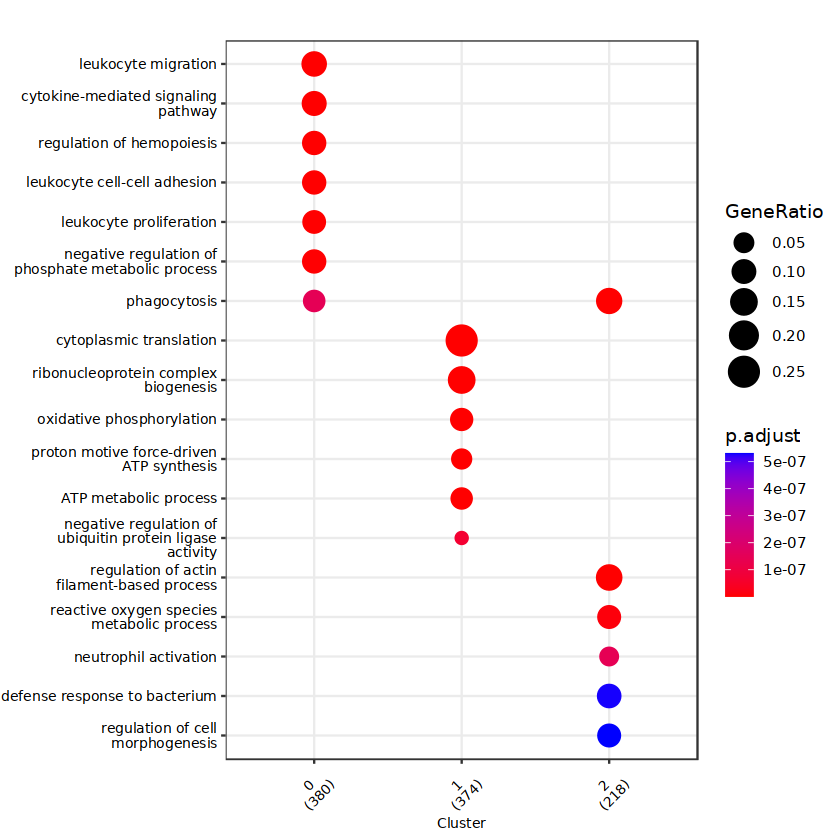

In [21]:
dotplot(data_GO_sim, showCategory=6,font.size = 8)+ theme(axis.text.x = element_text(angle = 45, 
 vjust = 0.5, hjust=0.5))

### compareclster kegg  http://www.360doc.com/content/24/0706/18/82995563_1128124683.shtml

In [31]:

data_KEGG <- compareCluster(
  ENTREZID~group, 
  data=data, 
  fun="enrichKEGG", 
  #OrgDb="org.Hs.eg.db",
    organism = 'hsa',
  pvalueCutoff = 0.01

  #readable = TRUE
)

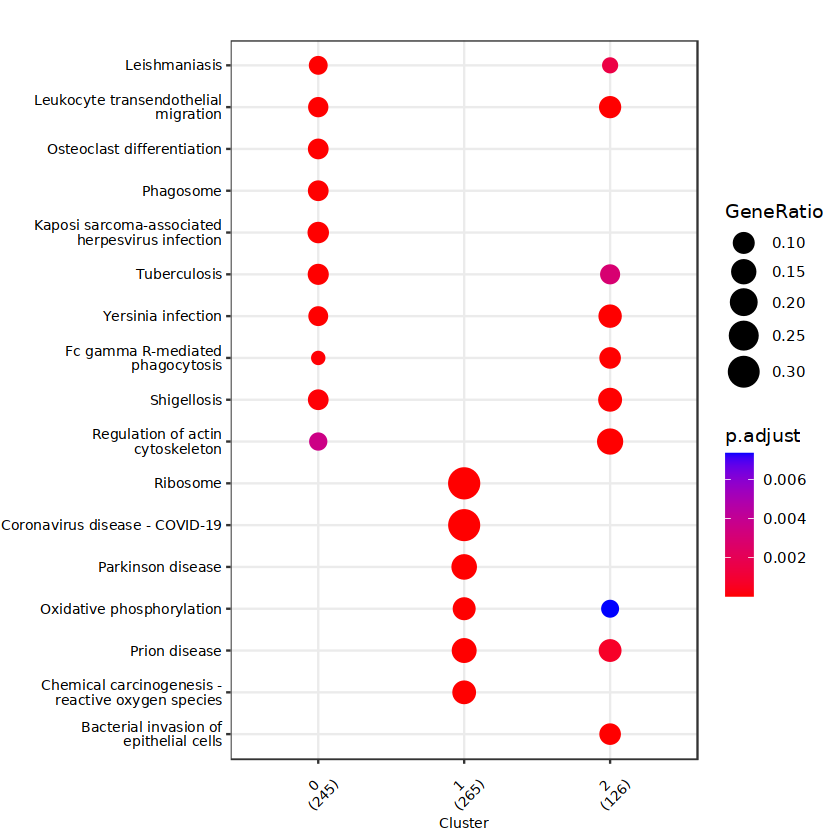

In [32]:
dotplot(data_KEGG, showCategory=6,font.size = 8)+ theme(axis.text.x = element_text(angle = 45, 
 vjust = 0.5, hjust=0.5))

### 单独比较0簇

In [34]:
Idents(sce) = 'seurat_clusters'

In [35]:
c0 = subset(sce,idents = 0)

In [37]:
table(c0$group)


     OS control 
    497    1940 

In [36]:
Idents(c0) = 'group'

In [40]:
DefaultAssay(c0) = 'RNA'

In [41]:
diffgene = FindMarkers(c0,ident.1 = 'OS')

In [43]:
Gene_ID <- bitr(rownames(diffgene), fromType="SYMBOL", 
            toType="ENTREZID", 
            OrgDb="org.Hs.eg.db")

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(rownames(diffgene), fromType = "SYMBOL", toType = "ENTREZID", :
"4.06% of input gene IDs are fail to map..."


In [45]:
gene <- Gene_ID[,2]
CC <- enrichGO(gene = gene,  #基因列表(转换的ID)
               keyType = "ENTREZID",  #指定的基因ID类型，默认为ENTREZID
               OrgDb=org.Hs.eg.db,  #物种对应的org包
               ont = "BP",   #CC细胞组件，MF分子功能，BP生物学过程
               pvalueCutoff = 0.01,  #p值阈值
               pAdjustMethod = "fdr",  #多重假设检验校正方式
               minGSSize = 1,   #注释的最小基因集，默认为10
               maxGSSize = 500,  #注释的最大基因集，默认为500
               qvalueCutoff = 0.01,  #q值阈值
               readable = TRUE)  #

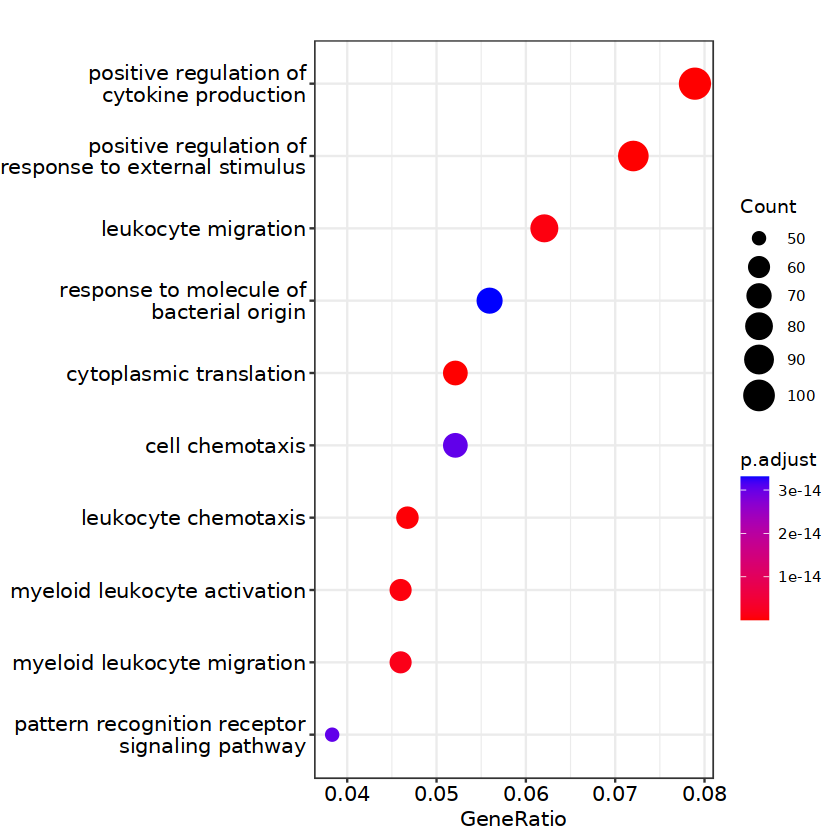

In [46]:
dotplot(CC)

In [47]:
ek <- enrichKEGG(gene =gene , 
               organism = "hsa",  
               pvalueCutoff =0.1, 
               qvalueCutoff = 0.1)

In [49]:
library("BioCor")
library("org.Hs.eg.db")
#library("reactome.db")
library(msigdbr)
library(clusterProfiler)
library(enrichplot)
library(reshape2)
library(corrplot)
library(plyr)
library(igraph) 

Warning message:
"package 'msigdbr' was built under R version 4.2.3"
Warning message:
"package 'enrichplot' was built under R version 4.2.2"
Warning message:
"package 'reshape2' was built under R version 4.2.3"
Warning message:
"package 'corrplot' was built under R version 4.2.3"
corrplot 0.92 loaded

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: 'plyr'


The following object is masked from 'package:IRanges':

    desc


The following object is masked from 'package:S4Vectors':

    rename


The following objects are masked from 'package:clusterProfiler':

    arrange, mutate, rename, summarise


The following objects are masked from 'package:dplyr':

    arrange, count, des

In [50]:
KEGG2 <- pairwise_termsim(ek)

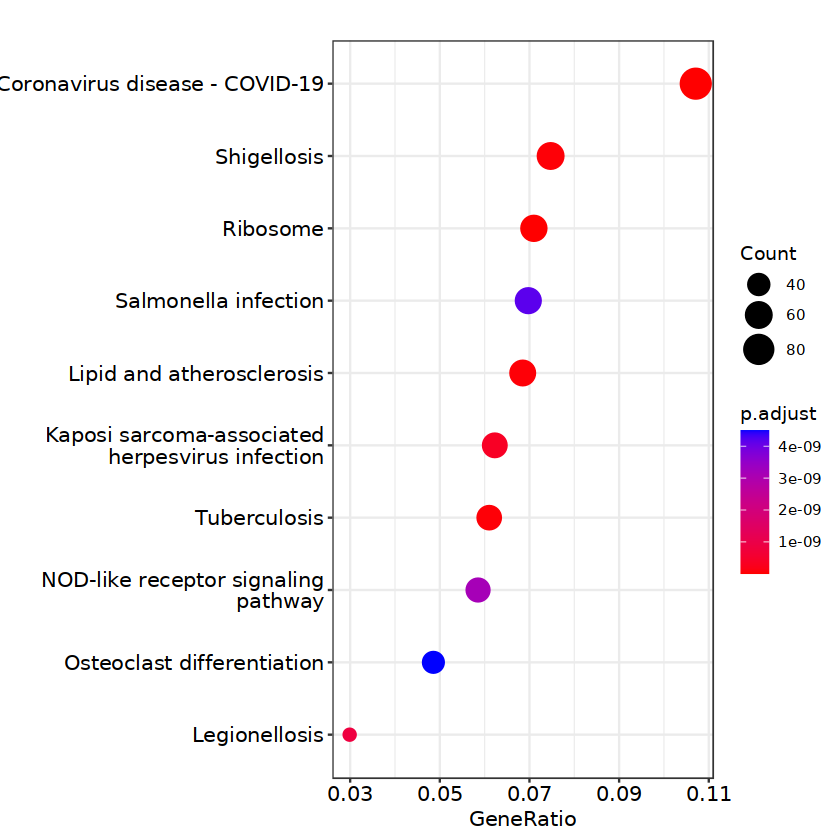

In [54]:
dotplot(KEGG2)